In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
# 데이터 로드
btc_data = pd.read_csv('./data/btc_usd.csv')
snpe_data = pd.read_csv('./data/snpe.csv')

# 공통 데이터 전처리 함수
def preprocess_data(df, date_column, price_column):
    # 날짜 데이터를 문자열로 변환 후 공백 제거
    df[date_column] = df[date_column].astype(str).str.replace(" ", "", regex=True)
    # 날짜 변환 (자동 포맷 감지)
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # 가격 데이터를 숫자로 변환
    df[price_column] = df[price_column].replace(',', '', regex=True).astype(float)
    
    # 날짜 기준 정렬
    df = df.sort_values(date_column)
    
    return df

# 각 데이터셋 전처리
btc_data = preprocess_data(btc_data, 'Date', 'Price')
snpe_data = preprocess_data(snpe_data, 'Date', 'Price')

# 필요한 열 선택 및 날짜 기준으로 병합
btc_data = btc_data[['Date', 'Price']].rename(columns={'Price': 'Bitcoin'})
snpe_data = snpe_data[['Date', 'Price']].rename(columns={'Price': 'SNPE'})

# 두 데이터를 날짜 기준으로 병합
merged_data = pd.merge(btc_data, snpe_data, on='Date', how='inner')

# 타겟값 추가 (미래 SNPE 예측)
merged_data['Target'] = merged_data['SNPE'].shift(-1)

# 결측치 제거 (타겟값 이동으로 인해 발생한 마지막 행 제거)
merged_data.dropna(inplace=True)

# 학습 및 테스트 데이터 분리
X = merged_data[['Bitcoin', 'SNPE']]
y = merged_data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 확인
print(merged_data.head())

# 모델 학습 및 시각화 함수
def train_and_visualize(data, feature_column, model_name):
    
    # 독립 변수(X) 및 종속 변수(y) 설정
    X = data[[feature_column]]
    y = data['Target']
    
    # 학습 및 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 사용할 모델 설정
    models = {
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    # 모델 학습
    model = models[model_name]
    model.fit(X_train, y_train)
    
    # 예측 수행
    predictions = model.predict(X_test)
    
    # 성능 평가 지표 계산
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
# 바 그래프 기반 예측 결과 시각화 함수
def train_and_visualize_bar_chart(data, feature_column, model_name):
    """
    주어진 데이터에 대해 모델을 학습하고 실제값(바 그래프)과 예측값(점 그래프)을 비교하는 그래프를 생성하는 함수
    
    :param data: 데이터 프레임
    :param feature_column: 사용할 특성 컬럼 (예: "SNPE", "Bitcoin")
    :param model_name: 사용할 모델 이름 ("Gradient Boosting", "Linear Regression", "Random Forest")
    """
    
    # 독립 변수(X) 및 종속 변수(y) 설정
    X = data[[feature_column]]
    y = data['Target']
    
    # 학습 및 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 사용할 모델 설정
    models = {
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    # 모델 학습
    model = models[model_name]
    model.fit(X_train, y_train)
    
    # 예측 수행
    predictions = model.predict(X_test)
    
    # 성능 평가 지표 계산
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # 샘플링 (최대 50개 데이터만 표시)
    num_samples = min(50, len(y_test))  
    sample_indices = np.arange(num_samples)
    
    # 시각화
    plt.figure(figsize=(15, 7))
    plt.bar(sample_indices, y_test.iloc[:num_samples], color='gray', alpha=0.6, label="A P")
    plt.scatter(sample_indices, predictions[:num_samples], color='blue', label=f'{model_name} P P', zorder=3)

    plt.title(f'{model_name} PREDICT ({feature_column})')
    plt.xlabel('DATE INDEX')
    plt.ylabel('TAGET VALUE(PRICE)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # 성능 출력
    print(f"{model_name} 모델 성능 ({feature_column}):")
    print(f"평균 제곱 오차 (MSE): {mse:.2f}")
    print(f"R² 점수: {r2:.2f}")
    print("-" * 50)

        Date  Bitcoin   SNPE  Target
0 2019-06-27  11200.0  25.09   25.20
1 2019-06-28  12349.0  25.20   25.42
2 2019-07-01  10639.0  25.42   25.49
3 2019-07-02  10866.0  25.49   25.69
4 2019-07-03  11984.0  25.69   25.63


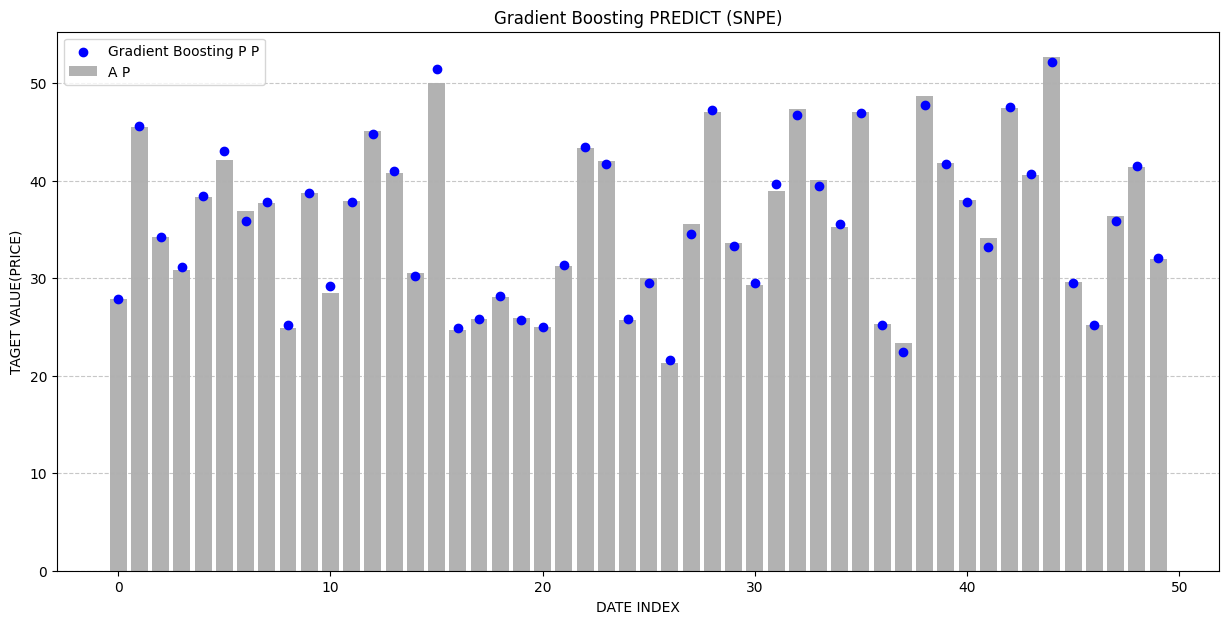

Gradient Boosting 모델 성능 (SNPE):
평균 제곱 오차 (MSE): 0.22
R² 점수: 1.00
--------------------------------------------------


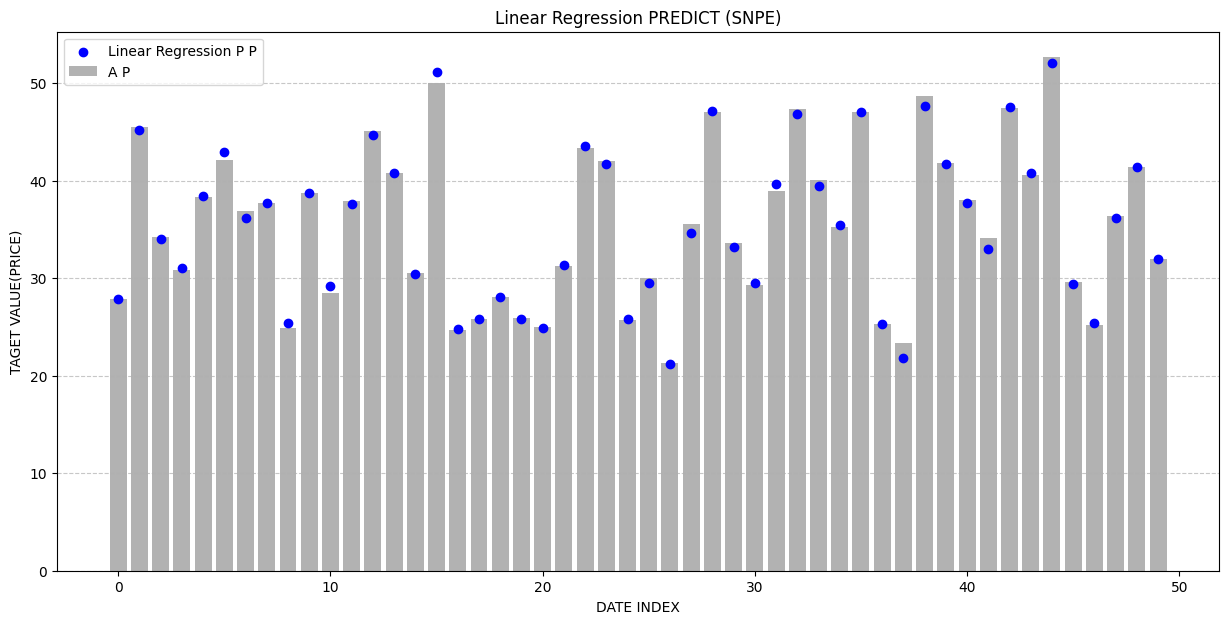

Linear Regression 모델 성능 (SNPE):
평균 제곱 오차 (MSE): 0.20
R² 점수: 1.00
--------------------------------------------------


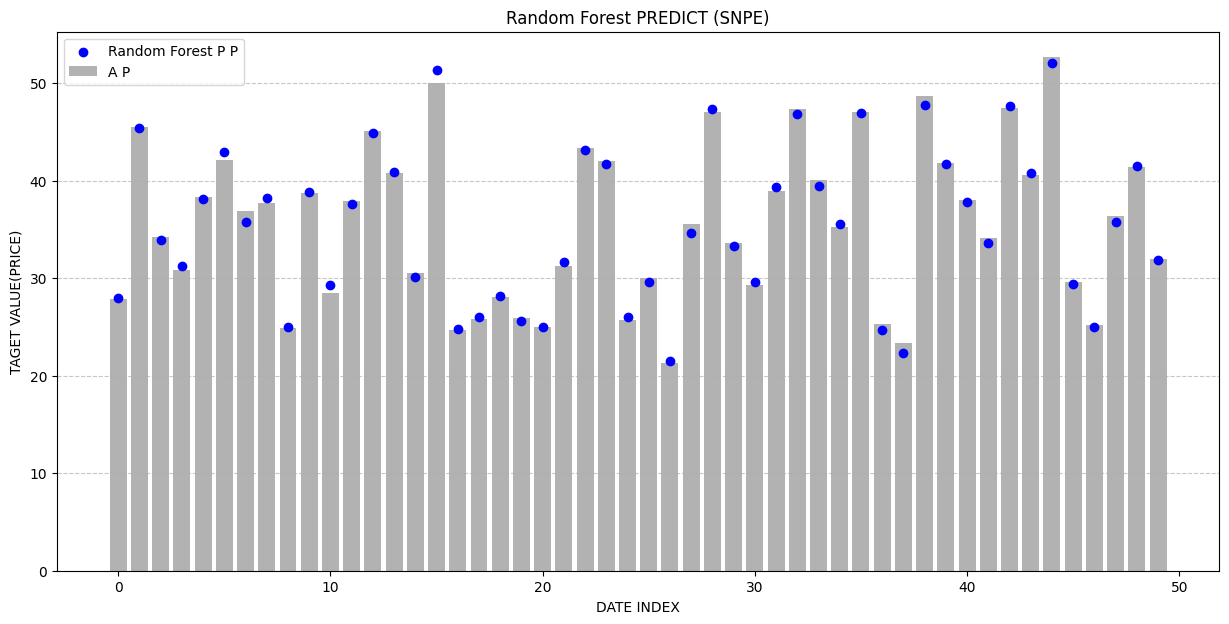

Random Forest 모델 성능 (SNPE):
평균 제곱 오차 (MSE): 0.25
R² 점수: 1.00
--------------------------------------------------


In [33]:
# KOSPI 컬럼명을 SNPE로 변경 (필요할 경우)
merged_data.rename(columns={"KOSPI": "SNPE"}, inplace=True)

# SNPE 데이터를 사용하여 바 그래프 기반 시각화 실행
train_and_visualize_bar_chart(merged_data, "SNPE", "Gradient Boosting")
train_and_visualize_bar_chart(merged_data, "SNPE", "Linear Regression")
train_and_visualize_bar_chart(merged_data, "SNPE", "Random Forest")



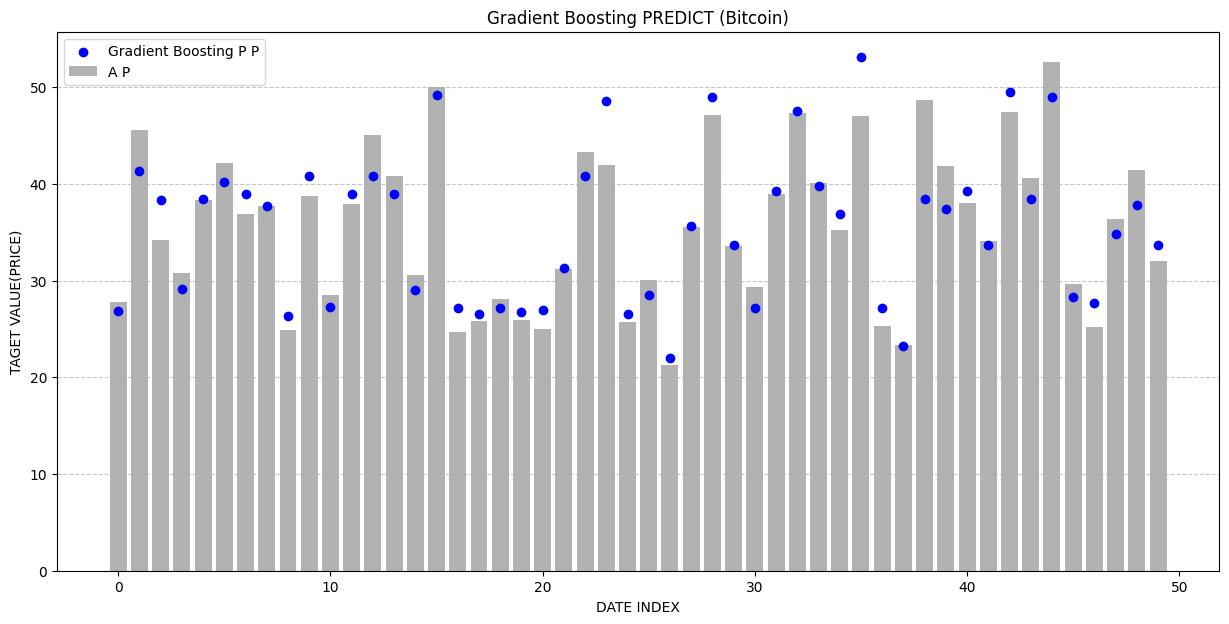

Gradient Boosting 모델 성능 (Bitcoin):
평균 제곱 오차 (MSE): 8.23
R² 점수: 0.87
--------------------------------------------------


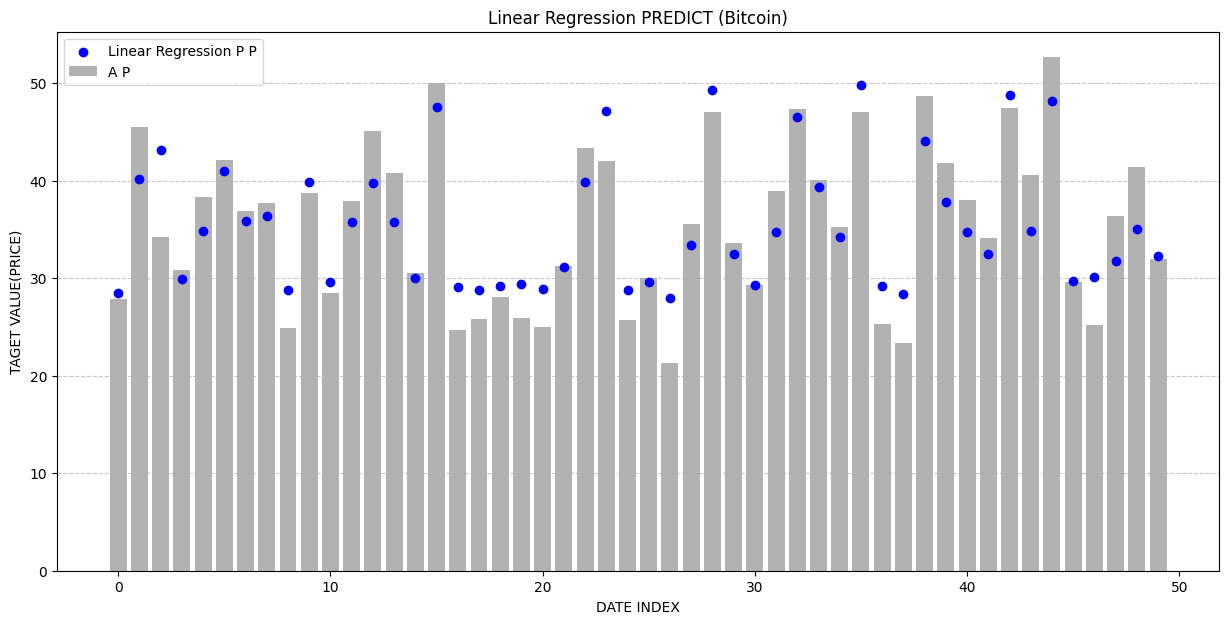

Linear Regression 모델 성능 (Bitcoin):
평균 제곱 오차 (MSE): 14.55
R² 점수: 0.77
--------------------------------------------------


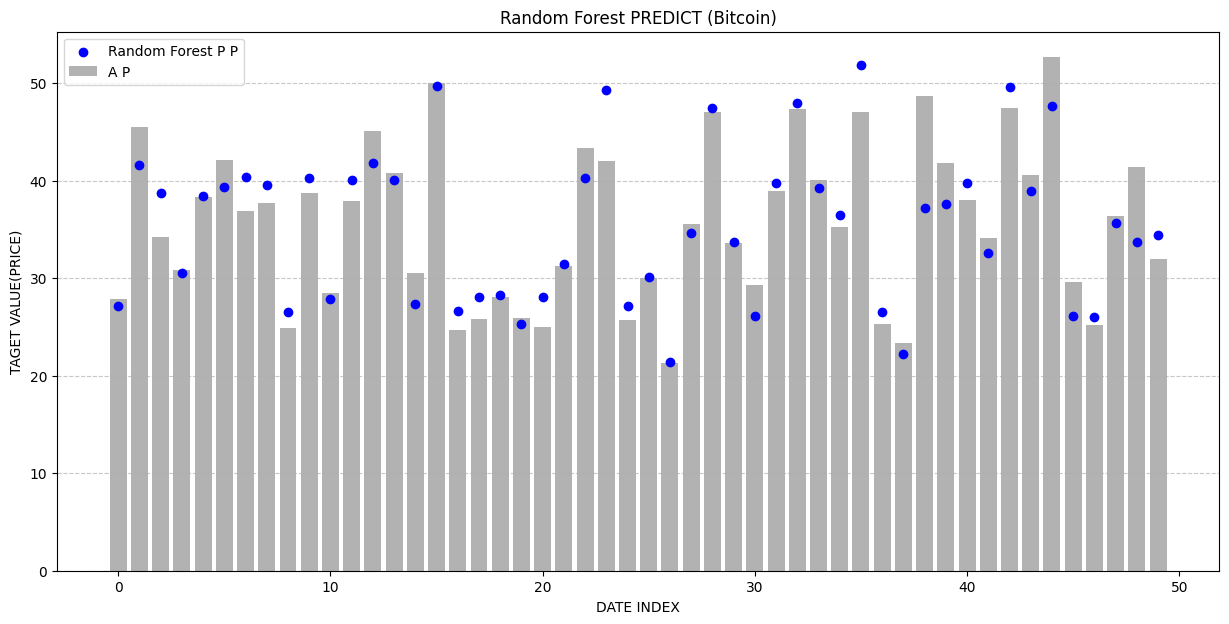

Random Forest 모델 성능 (Bitcoin):
평균 제곱 오차 (MSE): 11.40
R² 점수: 0.82
--------------------------------------------------


In [34]:
# Bitcoin 데이터를 사용하여 바 그래프 기반 시각화 실행
train_and_visualize_bar_chart(merged_data, "Bitcoin", "Gradient Boosting")
train_and_visualize_bar_chart(merged_data, "Bitcoin", "Linear Regression")
train_and_visualize_bar_chart(merged_data, "Bitcoin", "Random Forest")

# 성능 향상 방법 하이퍼파라미터 최적화 시도

- 하이퍼파라미터를 최적화하면 모델이 더욱 정밀해질 가능성이 큽니다.


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

print("PARAM GIRD:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

# 성능 향상 방법 2 LSTM 적용 시도 (찾아봄 공부해야겠음)

In [17]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


c:\Users\wjshi\anaconda3\envs\pystudy_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1361.0105 - val_loss: 816.9065
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 558.8021 - val_loss: 75.3810
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 77.4823 - val_loss: 63.9261
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69.5449 - val_loss: 62.6666
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 67.8292 - val_loss: 53.4531
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.7161 - val_loss: 13.6383
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.7069 - val_loss: 4.5560
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.8910 - val_loss: 2.9647
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.0773 - val_loss: 1.7160
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.6302 - val_loss: 1.6159
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.8915 - val_loss: 1.0971
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.3

In [28]:
# Bitcoin과 SNPE 데이터를 숫자로 변환
merged_data["Bitcoin"] = merged_data["Bitcoin"].astype(str).str.replace(",", "").astype(float)
merged_data["SNPE"] = merged_data["SNPE"].astype(str).str.replace(",", "").astype(float)

# Target 값 변환 (혹시라도 문제가 있을 경우 대비)
merged_data["Target"] = merged_data["Target"].astype(float)

# 변환된 데이터 확인
print(merged_data.head())


        Date  Bitcoin   SNPE  Target
0 2019-06-27  11200.0  25.09   25.20
1 2019-06-28  12349.0  25.20   25.42
2 2019-07-01  10639.0  25.42   25.49
3 2019-07-02  10866.0  25.49   25.69
4 2019-07-03  11984.0  25.69   25.63


c:\Users\wjshi\anaconda3\envs\pystudy_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wjshi\anaconda3\envs\pystudy_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44191 (\N{HANGUL SYLLABLE GES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wjshi\anaconda3\envs\pystudy_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wjshi\anaconda3\envs\pystudy_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wjshi\anaconda3\envs\pystudy_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANG

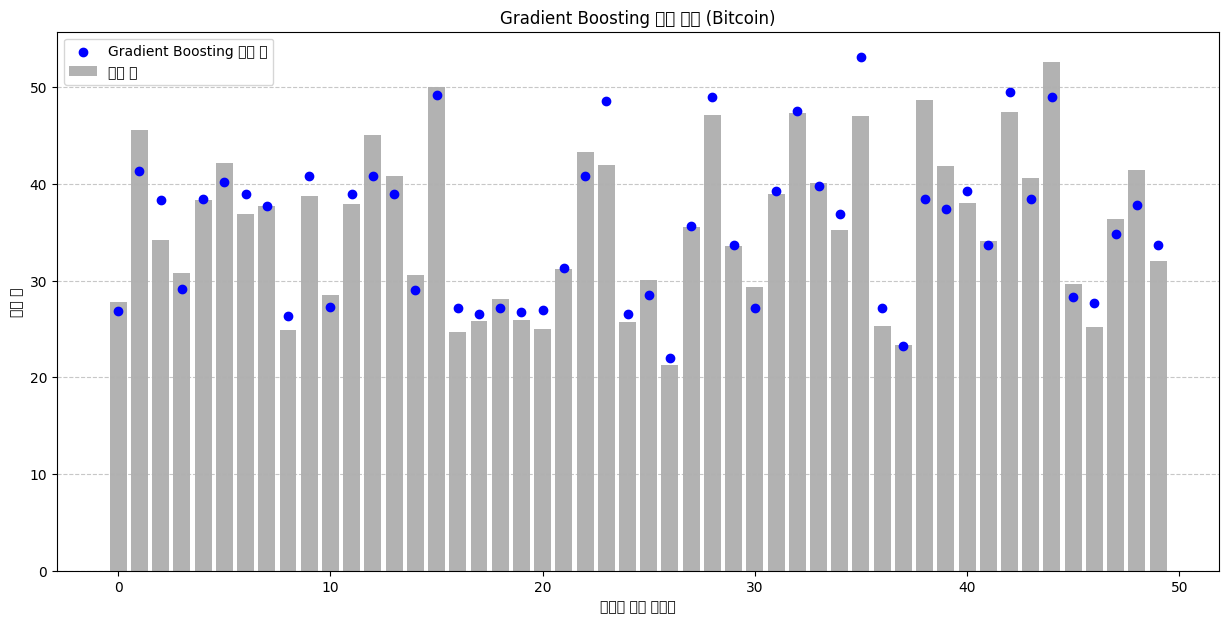

Gradient Boosting 모델 성능 (Bitcoin):
평균 제곱 오차 (MSE): 8.23
R² 점수: 0.87
--------------------------------------------------


In [29]:
# 변환된 데이터로 다시 학습 및 시각화 실행
train_and_visualize_bar_chart(merged_data, "Bitcoin", "Gradient Boosting")